### Init training pipeline with new models

#### Sub-modules 
- [har-imu-transformer](https://github.com/yolish/har-with-imu-transformer/tree/main)
- [sgn skeleton encoder](https://github.com/microsoft/SGN/tree/master)
- custom skeleton decoder

#### Training
- train with matching and non-matching IMU and skeleton pairs
- base on the objective functions for 
  - matching super class classification 
  - non-matching super class classification 
  - contrastive skeleton reconstruction 
  - binary matching constrastive learning 
- with pre-trained skeleton AE
- new correlation base loss

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install neptune
! pip install einops
! git clone https://github.com/nipdep/HAR-ZSL-XAI.git --branch duet --single-branch
! mv /content/HAR-ZSL-XAI/src /content/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 448.1/448.1 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 81.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 9.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.6 MB/s eta 0:00

---

In [3]:
import os 
import sys
from datetime import date, datetime
from tqdm.notebook import tqdm
from copy import deepcopy
from collections import defaultdict
import numpy as np 
import numpy.random as random
import pandas as pd
import json
import pickle
from collections import defaultdict, OrderedDict
# import neptune

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss

# sys.path.append('../')
from src.datasets.data import PAMAP2Reader, PAMAP2ReaderV2
# from src.datasets.dataset import PAMAP2Dataset
from src.utils.analysis import action_evaluator
from src.datasets.utils import load_attribute

from src.models.loss import FeatureLoss, AttributeLoss
from src.utils.losses import *
from src.utils.analysis import action_evaluator


from sklearn.metrics import accuracy_score

In [4]:
from sklearn.manifold import TSNE
# from umap import UMAP

import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px

In [5]:
os.system('CUDA_LAUNCH_BLOCKING=1')

0

---
Data Load

In [6]:
data_root = '/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Datasets/Consolidated/PAMPA2'

In [7]:
dataReader = PAMAP2ReaderV2(data_root+'/IMU/Protocol/')
actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


/content/src/datasets/data.py:1275: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [8]:
skeleton_data = np.load(data_root+'/Skeletons/skeleton_k10_movements.npz')
skeleton_classes, skeleton_mov = skeleton_data['arr_0'], skeleton_data['arr_1']

print(skeleton_mov.shape)
print(np.unique(skeleton_classes, return_counts=True))
print(dataReader.label_map)
print(np.unique(skeleton_classes, return_counts=True))

(180, 60, 36)
(array(['Nordic walking', 'ascending stairs', 'car driving',
       'computer work', 'cycling', 'descending stairs', 'folding laundry',
       'house cleaning', 'ironing', 'lying', 'playing soccer',
       'rope jumping', 'running', 'sitting', 'standing',
       'vacuum cleaning', 'walking', 'watching TV'], dtype='<U17'), array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10]))
[(1, 'lying'), (2, 'sitting'), (3, 'standing'), (4, 'walking'), (5, 'running'), (6, 'cycling'), (7, 'Nordic walking'), (9, 'watching TV'), (10, 'computer work'), (11, 'car driving'), (12, 'ascending stairs'), (13, 'descending stairs'), (16, 'vacuum cleaning'), (17, 'ironing'), (18, 'folding laundry'), (19, 'house cleaning'), (20, 'playing soccer'), (24, 'rope jumping')]
(array(['Nordic walking', 'ascending stairs', 'car driving',
       'computer work', 'cycling', 'descending stairs', 'folding laundry',
       'house cleaning', 'ironing', 'lying', 'playing soccer',
  

In [9]:
skeleton_mov.shape

(180, 60, 36)

In [10]:
action2label = {i:j for i,j in enumerate(dataReader.idToLabel)}
action2label

{0: 'lying',
 1: 'sitting',
 2: 'standing',
 3: 'walking',
 4: 'running',
 5: 'cycling',
 6: 'Nordic walking',
 7: 'watching TV',
 8: 'computer work',
 9: 'car driving',
 10: 'ascending stairs',
 11: 'descending stairs',
 12: 'vacuum cleaning',
 13: 'ironing',
 14: 'folding laundry',
 15: 'house cleaning',
 16: 'playing soccer',
 17: 'rope jumping'}

In [11]:
dataReader.idToLabel

['lying',
 'sitting',
 'standing',
 'walking',
 'running',
 'cycling',
 'Nordic walking',
 'watching TV',
 'computer work',
 'car driving',
 'ascending stairs',
 'descending stairs',
 'vacuum cleaning',
 'ironing',
 'folding laundry',
 'house cleaning',
 'playing soccer',
 'rope jumping']

In [12]:
class_hierarchy = {
    'static activities': ['lying', 'sitting', 'standing'],
    'walking activities': ['walking', 'Nordic walking', 'ascending stairs', 'descending stairs'],
    'house chores': ['vacuum cleaning', 'ironing', 'folding laundry', 'house cleaning'],
    'sports': ['running', 'cycling', 'playing soccer', 'rope jumping'],
    'sitting activities': ['watching TV', 'computer work', 'car driving']
}

In [13]:
super_class = {}
for i,j in class_hierarchy.items():
    for c in j:
        super_class[c] = i 

In [14]:
fold_classes = [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']]
unseen1 = fold_classes[0]

In [15]:
drop_hierarchy = defaultdict(list)
for i in unseen1:
    drop_hierarchy[super_class[i]].append(i)


In [16]:
active_hierarchy = {i:list(set(j)-set(drop_hierarchy[i])) for i,j in class_hierarchy.items()}
active_hierarchy

{'static activities': ['lying', 'sitting'],
 'walking activities': ['Nordic walking', 'walking', 'descending stairs'],
 'house chores': ['vacuum cleaning', 'folding laundry', 'ironing'],
 'sports': ['playing soccer', 'cycling', 'running', 'rope jumping'],
 'sitting activities': ['computer work', 'car driving']}

In [17]:
data_dict = dataReader.generate(unseen_classes=[0,1,2,3,4,5], seen_ratio=0.8, unseen_ratio=0.1, window_size=12, window_overlap=10, resample_freq=50)

In [18]:
class BaseDataset(Dataset):
    def __init__(self, imu_data, imu_actions, skel_data, skel_label, action2label, active_cls, class_hierarchy, skel_len=120):
        super(BaseDataset, self).__init__()
        self.imu_data = torch.from_numpy(imu_data)
        self.imu_actions = imu_actions
        new_fts = [i for i in range(skel_data.shape[-1]) if i%3 != 2]
        self.skel_data = torch.from_numpy(skel_data[:, :skel_len, new_fts])
        self.skel_label = skel_label
        self.action2label = action2label
        # build action to id mapping dict
        self.skel_len = skel_len
        self.active_cls = active_cls
        self.class_hierarchy = class_hierarchy

        self.n_action = len(self.active_cls)
        self.action2Id = dict(zip(active_cls, range(self.n_action)))
        print("action2Id : ", self.action2Id)
        self.Id2action = dict(zip(range(self.n_action), active_cls))
        self.super2Id = dict(zip(class_hierarchy.keys(), range(len(class_hierarchy))))
        self.__setup_skel_dict()
        self.__setup_super()
        self.__update_hierarchy()
    
    def __setup_skel_dict(self):
        action_dict = defaultdict(list)
        for i, c in enumerate(self.skel_label):
            if c in self.active_cls:
                action_dict[c].append(self.skel_data[i])
        
        self.skel_dict = action_dict #{i: np.array(j) for i,j in action_dict.items()}

    def __get_skel(self, lbl_ind):
        lbl = self.Id2action[lbl_ind]
        ind = random.randint(0, 10) # has to update
        skel = self.skel_dict[lbl][ind]
        return skel 
        
    def __setup_super(self):
        super_class = {}
        classes = []
        for i,j in self.class_hierarchy.items():
            for c in j:
                classes.append(c)
                super_class[c] = i 
        
        self.super_class = super_class 
        self.all_classes = classes
        print(self.super_class)

    def __update_hierarchy(self):
        self.active_hierarchy = defaultdict(list)
        for c in self.active_cls:
            self.active_hierarchy[self.super_class[c]].append(c)

    def __get_hierarchy(self, class_name):
        super_class = self.super_class[class_name]
        classes = self.active_hierarchy[super_class]
        return super_class, classes.copy()

    def __getitem__(self, ind):
        x = self.imu_data[ind, ...]
        anchor_action = self.imu_actions[ind]
        anchor_label = self.action2label[anchor_action]
        anchor_y = self.action2Id[anchor_label]
        
        super_label, siblings = self.__get_hierarchy(anchor_label)
        # print(super_label, siblings)
        super_y = self.super2Id[super_label]
        # print(siblings, anchor_label)
        siblings.remove(anchor_label)
        neg_label = random.choice(siblings)
        neg_y = self.action2Id[neg_label]

        anchor_skel = self.__get_skel(anchor_y)
        neg_skel = self.__get_skel(neg_y)
        return x, super_y, anchor_y, neg_y, anchor_skel, neg_skel

    def __len__(self):
        return self.imu_data.shape[0]


In [19]:
act_c = ['Nordic walking', 'watching TV', 'computer work', 'car driving', 'ascending stairs', 'descending stairs', 'vacuum cleaning', 'ironing', 'folding laundry', 'house cleaning', 'playing soccer', 'rope jumping']
# act_c = ['watching TV', 'house cleaning', 'standing', 'ascending stairs']
dataset = BaseDataset(imu_data=data_dict['train']['X'], imu_actions=data_dict['train']['y'], skel_data=skeleton_mov, skel_label=skeleton_classes, action2label=action2label, active_cls=act_c, class_hierarchy=class_hierarchy, skel_len=60)


action2Id :  {'Nordic walking': 0, 'watching TV': 1, 'computer work': 2, 'car driving': 3, 'ascending stairs': 4, 'descending stairs': 5, 'vacuum cleaning': 6, 'ironing': 7, 'folding laundry': 8, 'house cleaning': 9, 'playing soccer': 10, 'rope jumping': 11}
{'lying': 'static activities', 'sitting': 'static activities', 'standing': 'static activities', 'walking': 'walking activities', 'Nordic walking': 'walking activities', 'ascending stairs': 'walking activities', 'descending stairs': 'walking activities', 'vacuum cleaning': 'house chores', 'ironing': 'house chores', 'folding laundry': 'house chores', 'house cleaning': 'house chores', 'running': 'sports', 'cycling': 'sports', 'playing soccer': 'sports', 'rope jumping': 'sports', 'watching TV': 'sitting activities', 'computer work': 'sitting activities', 'car driving': 'sitting activities'}


In [20]:
np.unique(data_dict['train']['y'])

array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [21]:
dl =  DataLoader(dataset, batch_size=32, shuffle=True, pin_memory=True, drop_last=True)

In [22]:
for xi,si,yi,yni,skeli,skelni in dl:
    print(xi.shape, si.shape, yi.shape, yni.shape, skeli.shape, skelni.shape)
    print(yi)
    break

torch.Size([32, 24, 54]) torch.Size([32]) torch.Size([32]) torch.Size([32]) torch.Size([32, 60, 24]) torch.Size([32, 60, 24])
tensor([ 7,  0,  0,  9, 10,  8,  1,  0,  0,  0,  2,  2,  7,  5,  2,  0,  0,  5,
         9, 10,  6,  0,  5,  5,  8,  7,  0,  4,  0,  6,  2,  2])


In [23]:
class UnseenDataset(Dataset):
    def __init__(self, imu_data, imu_actions, skel_data, skel_label, action2label, active_cls, skel_len=120):
        super(UnseenDataset, self).__init__()
        self.imu_data = torch.from_numpy(imu_data)
        self.imu_actions = imu_actions
        new_fts = [i for i in range(skel_data.shape[-1]) if i%3 != 2]
        self.skel_data = skel_data[:, :skel_len, new_fts]
        self.skel_label = skel_label
        self.action2label = action2label
        # build action to id mapping dict
        self.skel_len = skel_len
        self.active_cls = active_cls
        self.n_action = len(self.active_cls)
        self.action2Id = dict(zip(active_cls, range(self.n_action)))
        self.Id2action = dict(zip(range(self.n_action), active_cls))
        self.__setup_skel_dict()

    def __setup_skel_dict(self):
        action_dict = defaultdict(list)
        for i, c in enumerate(self.skel_label):
            if c in self.active_cls:
                action_dict[c] = self.skel_data[i]
        
        self.skel_dict = action_dict
        self.skel_anchor = torch.from_numpy(np.array([action_dict[i] for i in self.active_cls]))

    def __getitem__(self, ind):
        x = self.imu_data[ind, ...]
        anchor_action = self.imu_actions[ind]
        anchor_label = self.action2label[anchor_action]
        anchor_id = self.action2Id[anchor_label]
        
        return x, anchor_id, self.skel_anchor

    def __len__(self):
        return self.imu_data.shape[0]

In [24]:
unseen_cls = ['lying', 'sitting', 'standing', 'walking', 'running', 'cycling']
unseen_dt = UnseenDataset(imu_data=data_dict['test']['X'], imu_actions=data_dict['test']['y'], skel_data=skeleton_mov, skel_label=skeleton_classes, action2label=action2label, active_cls=unseen_cls, skel_len=60)

unseen_dl =  DataLoader(unseen_dt, batch_size=32, shuffle=True, pin_memory=True, drop_last=True)

In [25]:
for ux, uy, uskels in unseen_dl:
    print(ux.shape, uy.shape, uskels.shape)
    break

torch.Size([32, 24, 54]) torch.Size([32]) torch.Size([32, 6, 60, 24])


---
Model Building

In [26]:
import math

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader

from torch.optim import Adam
from torch.nn import MSELoss,L1Loss

from src.models.bidirectional_cross_attention import BidirectionalCrossAttention

In [27]:
class BasicBlock(nn.Module):
    """
    Basic block is composed of 2 CNN layers with residual connection.
    Each CNN layer is followed by batchnorm layer and swish activation 
    function. 
    Args:
        in_channel: number of input channels
        out_channel: number of output channels
        k: (default = 1) kernel size
    """
    def __init__(self, in_channel, out_channel, k=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channel,
            out_channel,
            kernel_size=k,
            padding=(0, 0),
            stride=(1, 1))
        self.bn1 = nn.BatchNorm2d(out_channel)

        self.conv2 = nn.Conv2d(
            out_channel,
            out_channel,
            kernel_size=1,
            padding=(0, 0),
            stride=(1, 1))
        self.bn2 = nn.BatchNorm2d(out_channel)

        self.shortcut = nn.Sequential()
        # if in_channel != out_channel:
        self.shortcut.add_module(
            'conv',
            nn.Conv2d(
                in_channel,
                out_channel,
                kernel_size=k,
                padding=(0,0),
                stride=(1,1)))
        self.shortcut.add_module('bn', nn.BatchNorm2d(out_channel))

    def swish(self,x):
        """
        We use swish in spatio-temporal encoding/decoding. We tried with 
        other activation functions such as ReLU and LeakyReLU. But we 
        achieved the best performance with swish activation function.
        Args:
            X: tensor: (batch_size, ...)
        Return:
            _: tensor: (batch, ...): applies swish 
            activation to input tensor and returns  
        """
        return x*torch.sigmoid(x)

    def forward(self, x):
        y = self.swish(self.conv1(x))
        y = self.swish(self.conv2(y))
        y = y + self.shortcut(x)
        y = self.swish(y)
        return y


class BasicBlockTranspose(nn.Module):
    """
    Basic block is composed of 2 CNN layers with residual connection.
    Each CNN layer is followed by batchnorm layer and swish activation 
    function. 
    Args:
        in_channel: number of input channels
        out_channel: number of output channels
        k: (default = 1) kernel size
    """
    def __init__(self, in_channel, out_channel, k=(1,1)):
        super(BasicBlockTranspose, self).__init__()
        self.stride = (1, 1)
        self.padding = (0, 0)
        self.k = k
        self.conv1 = nn.ConvTranspose2d(
            in_channel,
            out_channel,
            kernel_size=k,
            padding=self.padding,
            stride=self.stride)
        self.bn1 = nn.BatchNorm2d(out_channel)

        self.conv2 = nn.ConvTranspose2d(
            out_channel,
            out_channel,
            kernel_size=1,
            padding=self.padding,
            stride=self.stride)
        self.bn2 = nn.BatchNorm2d(out_channel)

        self.shortcut = nn.Sequential()
        # if in_channel != out_channel:
        self.shortcut.add_module(
            'conv',
            nn.ConvTranspose2d(
                in_channel,
                out_channel,
                kernel_size=k,
                padding=self.padding,
                stride=self.stride))
        self.shortcut.add_module('bn', nn.BatchNorm2d(out_channel))

    def get_h_out(self,h_in):
        return (h_in - 1)*self.stride[0]-2*self.padding[0]+(self.k[0]-1)+1
    def get_w_out(self,w_in):
        return (w_in - 1)*self.stride[1]-2*self.padding[1]+(self.k[1]-1)+1

    def swish(self,x):
        """
        We use swish in spatio-temporal encoding/decoding. We tried with 
        other activation functions such as ReLU and LeakyReLU. But we 
        achieved the best performance with swish activation function.
        Args:
            X: tensor: (batch_size, ...)
        Return:
            _: tensor: (batch, ...): applies swish 
            activation to input tensor and returns  
        """
        return x*torch.sigmoid(x)

    def forward(self, x):
        y = self.swish(self.bn1(self.conv1(x)))
        y = self.swish(self.bn2(self.conv2(y)))
        y = y + self.shortcut(x)
        y = self.swish(y)
        return y



class Self_Attn_Seq(nn.Module):
    def __init__(self,in_dim, n_head=3):
        super(Self_Attn_Seq,self).__init__()
        input_dim = in_dim
        self.n_head = n_head # number of attenn head
        self.hidden_size_attention = input_dim // self.n_head
        self.w_q = nn.Linear(input_dim, self.n_head * self.hidden_size_attention)
        self.w_k = nn.Linear(input_dim, self.n_head * self.hidden_size_attention)
        self.w_v = nn.Linear(input_dim, self.n_head * self.hidden_size_attention)
        nn.init.normal_(self.w_q.weight, mean=0, std=np.sqrt(2.0 / (input_dim + self.hidden_size_attention)))
        nn.init.normal_(self.w_k.weight, mean=0,
                        std=np.sqrt(2.0 / (input_dim + self.hidden_size_attention)))
        nn.init.normal_(self.w_v.weight, mean=0,
                        std=np.sqrt(2.0 / (input_dim + self.hidden_size_attention)))
        self.temperature = np.power(self.hidden_size_attention, 0.5)

        self.softmax = nn.Softmax(dim=2)
        self.linear2 = nn.Linear(self.n_head * self.hidden_size_attention, input_dim)
        self.layer_norm = nn.LayerNorm(input_dim)
        self.gamma = nn.Parameter(torch.zeros(1))
    

    def forward(self, q):
        n_head = self.n_head
        residual = q
        k, v = q, q
        bs, len, _ = q.size()
        q = self.w_q(q).view(bs, len, n_head, self.hidden_size_attention)
        k = self.w_k(k).view(bs, len, n_head, self.hidden_size_attention)
        v = self.w_v(v).view(bs, len, n_head, self.hidden_size_attention)

        q = q.permute(2, 0, 1, 3).contiguous().view(-1, len, self.hidden_size_attention)
        k = k.permute(2, 0, 1, 3).contiguous().view(-1, len, self.hidden_size_attention)
        v = v.permute(2, 0, 1, 3).contiguous().view(-1, len, self.hidden_size_attention)

        # generate mask
        subsequent_mask = torch.triu(
            torch.ones((len, len), device=q.device, dtype=torch.uint8), diagonal=1)
        subsequent_mask = subsequent_mask.unsqueeze(0).expand(bs, -1, -1).gt(0)
        mask = subsequent_mask.repeat(n_head, 1, 1)

        # self attention
        attn = torch.bmm(q, k.transpose(1, 2)) / self.temperature
        attn = attn.masked_fill(mask, -np.inf)
        attn = self.softmax(attn)

        output = torch.bmm(attn, v)
        output = output.view(n_head, bs, len, self.hidden_size_attention)
        output = output.permute(1, 2, 0, 3).contiguous().view(bs, len, -1)
        output = self.gamma * self.linear2(output) + residual


        attn = attn.view(n_head,bs,len,len)
        attn_avg = torch.mean(attn,0)
        return output, attn_avg


class DSAGGenerator(nn.Module):
    def __init__(self,  
                 seq_len, 
                 input_size, 
                 embedding_size:int,
                 temporal_decoder_filters=[4,8,14,16],
                 feat_size = [2,4],
                 internal_attention = [168]
                 ):
        super(DSAGGenerator, self).__init__()
        self.embedding_size = embedding_size

        temporal_decoder_filters.append(seq_len-2)
        self.temporal_decoder_filters = temporal_decoder_filters

        self.latent_dim_inner = self.embedding_size//self.temporal_decoder_filters[0]

        self.input_size = input_size
        self.internal_attention = internal_attention
        self.feat_sizes = feat_size
        self.seq_len = seq_len

        #transpose blocks
        self.decode_s1 = BasicBlockTranspose(self.latent_dim_inner//self.feat_sizes[0], self.latent_dim_inner//self.feat_sizes[0], k=(3,1))
        self.decode_s2 = BasicBlockTranspose(self.internal_attention[0]//self.feat_sizes[1], self.internal_attention[0]//self.feat_sizes[1], k=(3,1))

        # decoder 
        self.conv1 = BasicBlock(1,1)
        self.conv2 = BasicBlock(1,1)
        self.conv3 = BasicBlock(1,1)
        self.conv4 = BasicBlock(1,1)
        self.decode_t = BasicBlock(self.temporal_decoder_filters[0],self.temporal_decoder_filters[1])
        self.decode_t1 = BasicBlock(self.temporal_decoder_filters[1],self.temporal_decoder_filters[2])
        self.decode_t2 = BasicBlock(self.decode_s1.get_h_out(self.temporal_decoder_filters[2]),
                                    self.temporal_decoder_filters[3])
        self.decode_t3 = BasicBlock(self.temporal_decoder_filters[3],self.temporal_decoder_filters[4])
        self.decode_t4 = BasicBlock(self.decode_s2.get_h_out(self.temporal_decoder_filters[4]),
                                    self.seq_len)

        # self attention layer
        self.decoder_attn1 = Self_Attn_Seq(self.latent_dim_inner)
        self.decoder_attn2 = Self_Attn_Seq(self.internal_attention[0])
        self.decoder = nn.Linear(self.latent_dim_inner, self.internal_attention[0])
        self.decoder1 = nn.Linear(self.internal_attention[0],self.input_size)

        
        # self.decode_s3 = BasicBlockTranspose(22, 22, k=(3,1))



    def forward(self, X):
        """0
        The deocder is opposit of the encoder. It takes the vector sampled
        from a mixture of gaussian parameter conditioned by class label on-
        hot vector and viewpoint vector, upsamples it in the temporal dimension 
        first and then upsamples it in the spatial dimension.
        Args:
            X: tensor: (batch_size, 4, ...): sampled vector conditionied on class 
            label and viewpoint
        Return:
            x: tensor: (batch_size, 32, 48, 6): generated human motion
        """

        N = X.shape[0]
        X = X.reshape((N,self.temporal_decoder_filters[0],-1))
        N,T,J = X.shape
        x, attn = self.decoder_attn1(X)

        # temporal decoding
        x = x.reshape((N,T,J//self.feat_sizes[0],self.feat_sizes[0]))
        x = self.decode_t(x)
        x = self.decode_t1(x)

        x = x.transpose(2,1)
        x = self.decode_s1(x)
        x = x.transpose(2,1)
        # pose decoding
        x = x.reshape((N*self.decode_s1.get_h_out(self.temporal_decoder_filters[2]),1,J//self.feat_sizes[0],self.feat_sizes[0]))
        x = self.conv1(x)
        x = x.reshape((N,self.decode_s1.get_h_out(self.temporal_decoder_filters[2]), -1))

        x = self.decoder(x)
        x, attn = self.decoder_attn2(x)

        N,T,J = x.shape
        # temporal decoding
        x = x.reshape((N,T,J//self.feat_sizes[1], self.feat_sizes[1]))
        x = self.decode_t2(x)
        x = self.decode_t3(x)

        x = x.transpose(2,1)
        x = self.decode_s2(x)
        x = x.transpose(2,1)
        # pose decoding
        x = x.reshape((N*self.seq_len,1,J//self.feat_sizes[1],self.feat_sizes[1]))
        x = self.conv2(x)
        x = x.reshape((N,self.seq_len, -1))
        x = self.decoder1(x)
        return x

class norm_data(nn.Module):
    def __init__(self, dim=3, joints=20):
        super(norm_data, self).__init__()

        self.bn = nn.BatchNorm1d(dim*joints)

    def forward(self, x):
        bs, c, num_joints, step = x.size()
        x = x.view(bs, -1, step)
        x = self.bn(x)
        x = x.view(bs, -1, num_joints, step).contiguous()
        return x

class embed(nn.Module):
    def __init__(self, dim=3, joint=20, hidden_dim=128, norm=True, bias=False):
        super(embed, self).__init__()

        if norm:
            self.cnn = nn.Sequential(
                norm_data(dim, joint),
                cnn1x1(dim, 64, bias=bias),
                nn.ReLU(),
                cnn1x1(64, hidden_dim, bias=bias),
                nn.ReLU(),
            )
        else:
            self.cnn = nn.Sequential(
                cnn1x1(dim, 64, bias=bias),
                nn.ReLU(),
                cnn1x1(64, hidden_dim, bias=bias),
                nn.ReLU(),
            )

    def forward(self, x):
        x = self.cnn(x)
        return x

class cnn1x1(nn.Module):
    def __init__(self, dim1 = 3, dim2 =3, bias = True):
        super(cnn1x1, self).__init__()
        self.cnn = nn.Conv2d(dim1, dim2, kernel_size=1, bias=bias)

    def forward(self, x):
        x = self.cnn(x)
        return x

class local(nn.Module):
    def __init__(self, dim1 = 3, dim2 = 3, bias = False):
        super(local, self).__init__()
        self.maxpool = nn.AdaptiveMaxPool2d((1, None))
        self.cnn1 = nn.Conv2d(dim1, dim1, kernel_size=(1, 3), padding=(0, 1), bias=bias)
        self.bn1 = nn.BatchNorm2d(dim1)
        self.relu = nn.ReLU()
        self.cnn2 = nn.Conv2d(dim1, dim2, kernel_size=1, bias=bias)
        self.bn2 = nn.BatchNorm2d(dim2)
        self.dropout = nn.Dropout2d(0.2)

    def forward(self, x1):
        x1 = self.maxpool(x1)
        x = self.cnn1(x1)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.cnn2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

class gcn_spa(nn.Module):
    def __init__(self, in_feature, out_feature, bias = False):
        super(gcn_spa, self).__init__()
        self.bn = nn.BatchNorm2d(out_feature)
        self.relu = nn.ReLU()
        self.w = cnn1x1(in_feature, out_feature, bias=False)
        self.w1 = cnn1x1(in_feature, out_feature, bias=bias)


    def forward(self, x1, g):
        x = x1.permute(0, 3, 2, 1).contiguous()
        x = g.matmul(x)
        x = x.permute(0, 3, 2, 1).contiguous()
        x = self.w(x) + self.w1(x1)
        x = self.relu(self.bn(x))
        return x

class compute_g_spa(nn.Module):
    def __init__(self, dim1 = 64 *3, dim2 = 64*3, bias = False):
        super(compute_g_spa, self).__init__()
        self.dim1 = dim1
        self.dim2 = dim2
        self.g1 = cnn1x1(self.dim1, self.dim2, bias=bias)
        self.g2 = cnn1x1(self.dim1, self.dim2, bias=bias)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x1):

        g1 = self.g1(x1).permute(0, 3, 2, 1).contiguous()
        g2 = self.g2(x1).permute(0, 3, 1, 2).contiguous()
        g3 = g1.matmul(g2)
        g = self.softmax(g3)
        return g
    

class SGN(nn.Module):
    def __init__(self, num_joint, seg, hidden_size=128, bs=32, is_3d=True, train=True, bias=True, device='cpu'):
        super(SGN, self).__init__()

        self.dim1 = hidden_size
        self.dim_unit = hidden_size // 4 
        self.seg = seg
        self.num_joint = num_joint
        self.bs = bs

        if is_3d:
          self.spatial_dim = 3
        else:
          self.spatial_dim = 2

        if train:
            self.spa = self.one_hot(bs, num_joint, self.seg)
            self.spa = self.spa.permute(0, 3, 2, 1).to(device)
            self.tem = self.one_hot(bs, self.seg, num_joint)
            self.tem = self.tem.permute(0, 3, 1, 2).to(device)
        else:
            self.spa = self.one_hot(32 * 5, num_joint, self.seg)
            self.spa = self.spa.permute(0, 3, 2, 1).to(device)
            self.tem = self.one_hot(32 * 5, self.seg, num_joint)
            self.tem = self.tem.permute(0, 3, 1, 2).to(device)

        self.tem_embed = embed(self.seg, joint=self.num_joint, hidden_dim=self.dim_unit*4, norm=False, bias=bias)
        self.spa_embed = embed(num_joint, joint=self.num_joint, hidden_dim=self.dim_unit, norm=False, bias=bias)
        self.joint_embed = embed(self.spatial_dim, joint=self.num_joint, hidden_dim=self.dim_unit, norm=True, bias=bias)
        self.dif_embed = embed(self.spatial_dim, joint=self.num_joint, hidden_dim=self.dim_unit, norm=True, bias=bias)
        self.maxpool = nn.AdaptiveMaxPool2d([1, 1])
        self.cnn = local(self.dim1, self.dim1 * 2, bias=bias)
        self.compute_g1 = compute_g_spa(self.dim1 // 2, self.dim1, bias=bias)
        self.gcn1 = gcn_spa(self.dim1 // 2, self.dim1 // 2, bias=bias)
        self.gcn2 = gcn_spa(self.dim1 // 2, self.dim1, bias=bias)
        self.gcn3 = gcn_spa(self.dim1, self.dim1, bias=bias)
        
        self.embed_maxpool = nn.AdaptiveMaxPool2d([self.dim1, 2])


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))

        nn.init.constant_(self.gcn1.w.cnn.weight, 0)
        nn.init.constant_(self.gcn2.w.cnn.weight, 0)
        nn.init.constant_(self.gcn3.w.cnn.weight, 0)


    def forward(self, input):
        
        # Dynamic Representation
        input = input.view((self.bs, self.seg, self.num_joint, self.spatial_dim))
        input = input.permute(0, 3, 2, 1).contiguous()
        dif = input[:, :, :, 1:] - input[:, :, :, 0:-1]
        dif = torch.cat([dif.new(self.bs, dif.size(1), self.num_joint, 1).zero_(), dif], dim=-1)
        # print(input.shape)
        pos = self.joint_embed(input)
        tem1 = self.tem_embed(self.tem)
        spa1 = self.spa_embed(self.spa)
        dif = self.dif_embed(dif)
        dy = pos + dif
        # Joint-level Module
        input= torch.cat([dy, spa1], 1)
        g = self.compute_g1(input)
        input = self.gcn1(input, g)
        input = self.gcn2(input, g)
        input = self.gcn3(input, g)
        # Frame-level Module
        input = input + tem1
        input = self.cnn(input)
        output_feat = torch.squeeze(input)
        output_feat = self.embed_maxpool(output_feat)
        output_feat = torch.flatten(output_feat, 1)

        return output_feat

    def one_hot(self, bs, spa, tem):

        y = torch.arange(spa).unsqueeze(-1)
        y_onehot = torch.FloatTensor(spa, spa)

        y_onehot.zero_()
        y_onehot.scatter_(1, y, 1)

        y_onehot = y_onehot.unsqueeze(0).unsqueeze(0)
        y_onehot = y_onehot.repeat(bs, tem, 1, 1)

        return y_onehot

class SGNClassifier(nn.Module):
  def __init__(self,num_classes,embedding_size, *args, **kwargs) -> None:
      super().__init__(*args, **kwargs)
      self.num_classes = num_classes
      self.embedding_size = embedding_size
      self.fc = nn.Linear(self.embedding_size, self.num_classes)

  def forward(self, input):
      output = self.fc(input)
      return output
    


class EncDecModel(nn.Module):
    def __init__(self,encoder,decoder,classifier):
        super(EncDecModel, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.classifier = classifier
        
    def forward(self,x):
        embedding = self.encoder(x)
        classifier_out = self.classifier(embedding)
        decoder_out = self.decoder(embedding)
        
        return decoder_out, embedding, classifier_out
        

In [28]:
class IMUTransformerEncoder(nn.Module):

    def __init__(self, config):
        """
        config: (dict) configuration of the model
        """
        super().__init__()

        self.transformer_dim = config.get("transformer_dim")

        self.input_proj = nn.Sequential(nn.Conv1d(config.get("input_dim"), self.transformer_dim, 1), nn.GELU(),
                                        nn.Conv1d(self.transformer_dim, self.transformer_dim, 1), nn.GELU(),
                                        nn.Conv1d(self.transformer_dim, self.transformer_dim, 1), nn.GELU(),
                                        nn.Conv1d(self.transformer_dim, self.transformer_dim, 1), nn.GELU())

        self.window_size = config.get("window_size")
        self.encode_position = config.get("encode_position")
        encoder_layer = TransformerEncoderLayer(d_model = self.transformer_dim,
                                       nhead = config.get("nhead"),
                                       dim_feedforward = config.get("dim_feedforward"),
                                       dropout = config.get("transformer_dropout"),
                                       activation = config.get("transformer_activation"))

        self.transformer_encoder = TransformerEncoder(encoder_layer,
                                              num_layers = config.get("num_encoder_layers"),
                                              norm = nn.LayerNorm(self.transformer_dim))
        self.cls_token = nn.Parameter(torch.zeros((1, self.transformer_dim)), requires_grad=True)

        if self.encode_position:
            self.position_embed = nn.Parameter(torch.randn(self.window_size + 1, 1, self.transformer_dim))

        # num_classes =  config.get("num_classes")
        output_size = config.get("output_size")
        self.imu_head = nn.Sequential(
            nn.AvgPool2d((self.window_size,1)),
            nn.Linear(self.transformer_dim,  output_size),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(output_size, output_size)
        )
        self.sigmoid = nn.Sigmoid()

        # init
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, data):
        src = data  # Shape N x S x C with S = sequence length, N = batch size, C = channels

        # Embed in a high dimensional space and reshape to Transformer's expected shape
        src = self.input_proj(src.transpose(1, 2)).permute(2, 0, 1)

        # Prepend class token
        cls_token = self.cls_token.unsqueeze(1).repeat(1, src.shape[1], 1)
        src = torch.cat([cls_token, src])

        # Add the position embedding
        if self.encode_position:
            src += self.position_embed

        # Transformer Encoder pass
        target = self.transformer_encoder(src)

        # Class probability
        target = torch.squeeze(target.permute(1,0,2))
        # target = self.imu_head(target)
        target = torch.squeeze(self.imu_head(target))
        return target

def get_activation(activation):
    """Return an activation function given a string"""
    if activation == "relu":
        return nn.ReLU(inplace=True)
    if activation == "gelu":
        return nn.GELU()
    raise RuntimeError("Activation {} not supported".format(activation))

In [29]:
class ContrastHead(nn.Module):
  def __init__(self, embedding_size):
        super(ContrastHead, self).__init__()
        self.imu_head = nn.Sequential(
            # nn.AvgPool2d((window_size,1)),
            # nn.Linear(embedding_size,  hidden_size),
            # nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(embedding_size, 1),
            nn.Sigmoid()
        )

  def forward(self, x):
        output = torch.squeeze(self.imu_head(x))
        return output

In [30]:
class SuperHead(nn.Module):
  def __init__(self, embedding_size, num_classes):
        super(SuperHead, self).__init__()
        self.imu_head = nn.Sequential(
            # nn.AvgPool2d((window_size,1)),
            # nn.Linear(embedding_size,  hidden_size),
            # nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(embedding_size, num_classes),
            # nn.Softmax(dim=-1)
        )

  def forward(self, x):
        output = self.imu_head(x)
        return output

In [31]:
# class BiLSTMDecoder(nn.Module):
#     def __init__(self,seq_len, input_size, hidden_size, linear_filters,embedding_size:int, num_layers = 1,bidirectional=True,device="cpu"):
#         super(BiLSTMDecoder, self).__init__()
#         self.input_size = input_size
#         self.hidden_size = hidden_size
#         self.device = device
#         self.num_layers = num_layers
#         self.linear_filters = linear_filters[::-1]
#         self.embedding_size = embedding_size
#         self.bidirectional = bidirectional
#         self.seq_len = seq_len

#         if bidirectional:
#             self.input_linear = nn.Linear(self.embedding_size,4*self.hidden_size)
#         else:
#             self.input_linear = nn.Linear(self.embedding_size,2*self.hidden_size)

#         # define LSTM layer
#         self.layers = []
#         # add lstm
#         self.lstm = nn.LSTM(input_size = self.linear_filters[0], hidden_size = self.hidden_size,
#                             num_layers = self.num_layers, bidirectional=True,
#                             batch_first=bidirectional)

                        
#         # add linear layers 
#         if bidirectional:
#             self.layers.append(nn.Linear(2*hidden_size,self.linear_filters[0]))
#         else:
#             self.layers.append(nn.Linear(hidden_size,self.linear_filters[0]))

#         for __id,layer_in in enumerate(self.linear_filters):
#             if __id == len(linear_filters)-1:
#                 self.layers.append(nn.Linear(layer_in,self.input_size))
#             else:
#                 self.layers.append(nn.Linear(layer_in,self.linear_filters[__id+1]))

#         self.net = nn.Sequential(*self.layers)

        
        

#     def forward(self,encoder_hidden):
#         """
#         : param x_input:               input of shape (seq_len, # in batch, input_size)
#         : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence; hidden gives the hidden state and cell state for the last element in the sequence
#         """
        
        
#         hidden_shape = encoder_hidden.shape
#         encoder_hidden = self.input_linear(encoder_hidden)
        
#         if self.bidirectional:
#             hidden = encoder_hidden.view((-1,4,self.hidden_size))
#             hidden = torch.transpose(hidden,1,0)
#             h1,h2,c1,c2 = torch.unbind(hidden,0)
#             h,c = torch.stack((h1,h2)),torch.stack((c1,c2))
#             bs = h.size()[1]
#         else:
#             hidden = encoder_hidden.view((-1,2,self.hidden_size))
#             hidden = torch.transpose(hidden,1,0)
#             h,c = torch.unbind(hidden,0)
#             bs = h.size()[1]
        
#         dummy_input = torch.rand((bs,self.seq_len,self.hidden_size), requires_grad=True).to(self.device)
        
#         lstm_out, self.hidden = self.lstm(dummy_input,(h,c))
#         x = self.net(lstm_out)
        
#         return x

In [32]:
class BaseModel(nn.Module):
    def __init__(self, config):
        super(BaseModel, self).__init__()
        self.device = config['device']
        self.imu_model = IMUTransformerEncoder(config['imu_config'])
        self.skel_encoder = SGN(**config['sgn_config'])
        self.skel_decoder = DSAGGenerator(**config['dec_config'])
        # self.contrast_head = ContrastHead(**config['contrast_config'])
        self.super_head = SuperHead(**config['super_config'])
        self.lxmert_xlayer = BidirectionalCrossAttention(**config['xmert_config'])

        self.sigmoid = nn.Sigmoid()
        self.imu_mask = torch.ones((config['bs'], config['imu_len']), requires_grad=True).bool().to(self.device)
        self.skel_mask = torch.ones((config['bs'], config['skel_len']), requires_grad=True).bool().to(self.device)
        

    def forward(self, x_imu, x_skel):
        imu_feats = self.imu_model(x_imu)
        skel_feats = self.skel_encoder(x_skel)
        imu_feats = torch.unsqueeze(imu_feats, dim=1)
        skel_feats = torch.unsqueeze(skel_feats, dim=1)
        # print(f"imu_feats {imu_feats.shape} | skel_feats {skel_feats.shape}")
        imu_feats, skel_feats = self.lxmert_xlayer(imu_feats, skel_feats, mask=self.imu_mask, context_mask=self.skel_mask)
        # print(f"imu_feats {imu_feats.shape} | skel_feats {skel_feats.shape}")
        # skel_recon = self.skel_decoder(skel_feats)
        # imu_feats = torch.squeeze(imu_feats)
        # bin_output = torch.squeeze(self.fc_head(imu_feats))
        # print(f"imu_feats {imu_feats.shape} | skel_feats {skel_feats.shape}")
        contrast_out = torch.squeeze(torch.bmm(imu_feats, torch.transpose(skel_feats, 1, 2)))
        contrast_out = self.sigmoid(contrast_out)
        imu_feats = torch.squeeze(imu_feats)
        skel_feats = torch.squeeze(skel_feats)
        # print(f"imu_feats {imu_feats.shape} | skel_feats {skel_feats.shape}")
        # contrast_out = self.contrast_head(imu_feats)
        super_out = self.super_head(imu_feats)

        imu_skel_recon = self.skel_decoder(imu_feats)
        skel_skel_recon = self.skel_decoder(skel_feats)
        return contrast_out, super_out, imu_skel_recon, skel_skel_recon

In [33]:
a1 = torch.randn(32, 1, 128)
a2 = torch.randn(32, 1, 128)
corr = torch.bmm(a1, torch.transpose(a2, 1, 2))
corr.shape

torch.Size([32, 1, 1])

In [34]:
imu_config = {
	"input_dim": 54,
    "window_size":24,
	"encode_position":True,
	"transformer_dim": 512,
	"nhead": 8,
	"num_encoder_layers": 6, 
	"dim_feedforward": 128, 
	"transformer_dropout": 0.1, 
	"transformer_activation": "gelu",
	"head_activation": "gelu",
    "baseline_dropout": 0.1,
	"batch_size": 32,
	"output_size": 512
}

sgn_config = {
    'num_joint': 12,
    'seg': 60,
    'hidden_size': 256,
    'train': True,
    'bs': 32,
    'device': 'cpu',
    'is_3d': False
}


# dec_config = {
#     'seq_len': 60,
#     'input_size': 24,
#     'hidden_size': 256,
#     'num_layers': 2,
#     'bidirectional': True,
#     "embedding_size": 128,
#     "linear_filters":[128,256,512,1024],
# }

dec_config = {
    'seq_len': 60,
    'input_size': 24,
    # 'hidden_size': 256,
    # 'linear_filters': [128, 256],
    'embedding_size': 512,
    # 'num_layers': 1,
    # 'output_size': 24,
    # 'bidirectional': True,
    # 'device': 'cpu'
}

# seq_len, input_size, hidden_size, linear_filters, embedding_size:int, num_layers = 1, bidirectional=True, device='cpu'

contrast_config = {
    'embedding_size': 512
}

super_config = {
    'embedding_size': 512,
    'num_classes': 5
}

base_config = {
    'imu_config': imu_config,
    'sgn_config': sgn_config,
    'dec_config': dec_config,
    'contrast_config': contrast_config,
    'super_config': super_config,
    'device': 'cpu',
    'bs': 32,
    'imu_len': 1,
    'skel_len': 1,
    'ft_size': 512,
    'xmert_config': {
            'dim': 512,
            'heads': 8,
            'dim_head': 64,
            'context_dim': 512,   
    }
}
 
base_model = BaseModel(base_config)

In [35]:
imu_input = torch.randn([32, 24, 54])
skel_input = torch.randn([32, 60, 24])
con_out, sup_out, skel_out, recon_out = base_model(imu_input, skel_input)
print(con_out.shape, sup_out.shape, skel_out.shape, recon_out.shape)

torch.Size([32]) torch.Size([32, 5]) torch.Size([32, 60, 24]) torch.Size([32, 60, 24])


---
Training Pipeline

In [36]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [37]:
def train_step(model, dl, optimizer, loss_modules, loss_weights, device, phase='train', loss_alpha=0.7):
    model = model.train()

    with tqdm(dl, unit='batch', desc=phase) as tepoch:
        for batch in tepoch:
            x, super_y, anchor_y, neg_y, anchor_skel, neg_skel = batch 
            x = x.float().to(device)
            super_y = super_y.long().to(device)
            anchor_y = anchor_y.float().to(device)
            neg_y = neg_y.float().to(device)
            anchor_skel = anchor_skel.float().to(device)
            neg_skel = neg_skel.float().to(device)
            # print(f"X : {X.shape} | skel : {skel.shape}")

            optimizer.zero_grad()
            with torch.set_grad_enabled(phase=='train'):
                pos_bin, pos_mul, pos_recon, skel_recon = model(x, anchor_skel)
                neg_bin, neg_mul, neg_recon, _ = model(x, neg_skel)
                # print("cls_prob : ", cls_prob.shape, " skel_recon :", skel_recon.shape)
            
            # multi-class classification 
            matching_super_loss = loss_modules['mul_class'](pos_mul, super_y)
            non_matching_super_loss = loss_modules['mul_class'](neg_mul, super_y)
            # binary classification
            y = torch.ones_like(super_y).float().to(device)
            marginal_loss = loss_modules['marginal_loss'](pos_bin, neg_bin, y)
            # skeleton reconstruction 
            imu_recon_loss = loss_modules['l2_loss'](anchor_skel, pos_recon)
            skel_recon_loss = loss_modules['l2_loss'](anchor_skel, skel_recon)

            loss = loss_weights['alpha']*(matching_super_loss+non_matching_super_loss) + loss_weights['beta']*(imu_recon_loss+skel_recon_loss) + loss_weights['gamma']*marginal_loss

            if phase == 'train':
                loss.backward()
                optimizer.step()

            # for name, param in model.named_parameters():
            #     print(name, param.grad.max())

            metrics = {"loss": loss.item(), 'matching super class loss': matching_super_loss.item(), 'non matching super class loss': non_matching_super_loss.item(),
                       'matching marginal loss': marginal_loss.item(), 'imu reconstruction loss': imu_recon_loss.item(), 'skel reconstruction loss': skel_recon_loss.item()}
            tepoch.set_postfix({"loss": loss.item()})
            # pred_class = cls_prob.cpu().detach().numpy()
            y_pred = (pos_bin.cpu().detach().numpy() >= 0.5).astype(int)
            # print("y_true : ", y.cpu().detach().numpy().astype(int), " y_pred : ", pred_class)
            metrics["accuracy"] = accuracy_score(y_true=y.cpu().detach().numpy().astype(int), y_pred=y_pred)
            
        return metrics 

In [38]:
def validate_step(model, dl, optimizer, loss_modules, loss_weights, device, class_names, phase='train', loss_alpha=0.7, print_report=False, show_plot=False):
    model = model.eval()
    per_batch = {'targets': [], 'bin_pred': [], 'super_pred': [], 'super_target': [], 'metrics': []}
    metrics = {"samples": 0, "loss": 0, 'matching super class loss': 0, 'non matching super class loss': 0,
                       'matching marginal loss': 0, 'imu reconstruction loss': 0, 'skel reconstruction loss': 0}

    with tqdm(dl, unit='batch', desc=phase) as tepoch:
        for batch in tepoch:
            x, super_y, anchor_y, neg_y, anchor_skel, neg_skel = batch 
            x = x.float().to(device)
            super_y = super_y.long().to(device)
            anchor_y = anchor_y.float().to(device)
            neg_y = neg_y.float().to(device)
            anchor_skel = anchor_skel.float().to(device)
            neg_skel = neg_skel.float().to(device)
            # print(f"X : {X.shape} | skel : {skel.shape}")

            optimizer.zero_grad()
            with torch.set_grad_enabled(phase=='train'):
                pos_bin, pos_mul, pos_recon, skel_recon = model(x, anchor_skel)
                neg_bin, neg_mul, neg_recon, _ = model(x, neg_skel)
                # print("cls_prob : ", cls_prob.shape, " skel_recon :", skel_recon.shape)
            
            # multi-class classification 
            matching_super_loss = loss_modules['mul_class'](pos_mul, super_y)
            non_matching_super_loss = loss_modules['mul_class'](neg_mul, super_y)
            # binary classification
            y = torch.ones_like(super_y).float().to(device)
            marginal_loss = loss_modules['marginal_loss'](pos_bin, neg_bin, y)
            # skeleton reconstruction 
            imu_recon_loss = loss_modules['l2_loss'](anchor_skel, pos_recon)
            skel_recon_loss = loss_modules['l2_loss'](anchor_skel, skel_recon)

            loss = loss_weights['alpha']*(matching_super_loss+non_matching_super_loss) + loss_weights['beta']*(imu_recon_loss+skel_recon_loss) + loss_weights['gamma']*marginal_loss

            with torch.no_grad():
                metrics['samples'] += len(y)
                metrics['loss'] += loss.item()  # add total loss of batch
                metrics['matching super class loss'] += matching_super_loss.item()
                metrics['non matching super class loss'] += non_matching_super_loss.item()
                metrics['matching marginal loss'] += marginal_loss.item()
                metrics['imu reconstruction loss'] += imu_recon_loss.item()
                metrics['skel reconstruction loss'] += skel_recon_loss.item()

            y_pred = (pos_bin.cpu().detach().numpy() >= 0.5).astype(int)
            per_batch['targets'].append(y.cpu().numpy())
            per_batch['bin_pred'].append(y_pred)
            per_batch['super_pred'].append(pos_mul.cpu().detach().numpy())
            per_batch['super_target'].append(super_y.cpu().detach().numpy())
            per_batch['metrics'].append([loss.detach().cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})

    all_preds = np.concatenate(per_batch["bin_pred"])
    all_super_preds = np.concatenate(per_batch["super_pred"])
    all_targets = np.concatenate(per_batch["targets"])
    all_super_targets = np.concatenate(per_batch["super_target"])
    
    metrics["binary accuracy"] = accuracy_score(y_true=all_targets.astype(int), y_pred=all_preds)
    super_classes = ['static activities', 'walking activities', 'house chores', 'sports', 'sitting activities']
    metrics_dict = action_evaluator(y_pred=np.argmax(all_super_preds,axis=1), y_true=all_super_targets.astype(int), class_names=super_classes, print_report=print_report, show_plot=show_plot)
    metrics_dict.update(metrics)
    return metrics_dict

In [39]:
def unseen_eval(model, unseen_dl, device, class_names, print_report=True, show_plot=True):
    model = model.eval()
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': [], 'feat': []}
    metrics = {"samples": 0, "loss": 0, "recon. loss": 0, "classi. loss": 0}

    with tqdm(unseen_dl, unit='batch') as tepoch:
        for batch in tepoch:
            X, y, skels = batch 
            X = X.float().to(device)
            y = y.long()
            skels = skels.float().to(device)

        skels = skels.permute(1,0,2,3)
        preds = []
        for i in range(len(class_names)):
            with torch.no_grad():
                cls_prob, _, _, _ = model(X, skels[i, ...])
                preds.append(cls_prob.cpu().detach().numpy())
            
        preds = np.array(preds)
        # print("preds shape : ", preds.shape)
        per_batch['targets'].append(y.cpu().numpy())
        per_batch['predictions'].append(preds)

    all_preds = np.argmax(np.concatenate(per_batch["predictions"]).T, axis=-1)
    all_targets = np.concatenate(per_batch["targets"]).astype(int)
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets, class_names=class_names, print_report=print_report, show_plot=show_plot)

    return metrics_dict

In [40]:
def plot_curves(df):
    df['loss'] = df['loss']/df['samples']
    df['matching super class loss'] = df['matching super class loss']/df['samples']
    df['non matching super class loss'] = df['non matching super class loss']/df['samples']
    df['matching marginal loss'] = df['matching marginal loss']/df['samples']
    df['imu reconstruction loss'] = df['imu reconstruction loss']/df['samples']
    df['skel reconstruction loss'] = df['skel reconstruction loss']/df['samples']
    
    fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))
    sns.lineplot(data=df, x='epoch', y='loss', hue='phase', marker='o', ax=axs[0,0]).set(title="Loss")
    sns.lineplot(data=df, x='epoch', y='matching super class loss', hue='phase', marker='o', ax=axs[1,0]).set(title="Matching Super-class Classification Loss")
    sns.lineplot(data=df, x='epoch', y='non matching super class loss', hue='phase', marker='o', ax=axs[2,0]).set(title="Non-matching Super-class Classification Loss")
    sns.lineplot(data=df, x='epoch', y='matching marginal loss', hue='phase', marker='o', ax=axs[3,0]).set(title="Matching Marginal binary loss")
    sns.lineplot(data=df, x='epoch', y='imu reconstruction loss', hue='phase', marker='o', ax=axs[2,1]).set(title="imu reconstruction loss")
    sns.lineplot(data=df, x='epoch', y='skel reconstruction loss', hue='phase', marker='o', ax=axs[3,1]).set(title="skel reconstruction loss")
    sns.lineplot(data=df, x='epoch', y='accuracy', hue='phase', marker='o', ax=axs[0,1]).set(title="Super class Accuracy")
    sns.lineplot(data=df, x='epoch', y='binary accuracy', hue='phase', marker='o', ax=axs[1,1]).set(title="Binary Accuracy")

---
Run

In [51]:
config = {
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2", # "PAMAP2", "DaLiAc", "UTD"
    "Model": "Transfomer-Encder",
    "sem-space": 'I3D',
    # model training configs
    "lr": 0.0001,
    "loss_alpha": 0.1,
    "n_epochs": 20,
    "batch_size": 128,
    # model configs
    "feat_size": 256, # skel-AE hidden size and IMU-Anc output size
    # dataset configs
    "window_size": 12, 
    "overlap": 10,
    "freq": 50,
    "seq_len": 60,  # skeleton seq. length
    "seen_split": 0.1,
}

In [52]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [53]:
data_dict = dataReader.generate(unseen_classes=[1,2], seen_ratio=config['seen_split'], unseen_ratio=0.8, window_size=config['window_size'], window_overlap=config['overlap'], resample_freq=config['freq'])
dl =  DataLoader(dataset, batch_size=8, shuffle=True, pin_memory=True, drop_last=True)
for x,_, _, _ ,skel, _ in dl:
    _, seq_len, imu_feat = x.shape 
    _, timestamps, joints = skel.shape
    break

In [54]:
imu_config = {
	"input_dim": imu_feat, # 
  "window_size": seq_len, # 
	"encode_position":True,
	"transformer_dim": 256, ##
	"nhead": 8,
	"num_encoder_layers": 6, 
	"dim_feedforward": 128, 
	"transformer_dropout": 0.1, 
	"transformer_activation": "gelu",
	"head_activation": "gelu",
  "baseline_dropout": 0.1,
	"batch_size": 32,
	"output_size": config['feat_size'] ##
}

# imuenc_config = {
#     'in_ft': imu_feat,
#     'd_model': 256,
#     'ft_size': config['feat_size'],
#     'num_heads': 2,
#     'max_len': seq_len,
#     'dropout': 0.1
# }

sgn_config = {
    'num_joint': joints//2, #
    'seg': timestamps, #
    'hidden_size': config['feat_size']//2, 
    'train': True,
    'bs': config['batch_size'], ##
    'is_3d': False,
    'device': device
}

# dec_config = {
#     'seq_len': timestamps, #
#     'input_size': joints, #
#     'hidden_size': 256, 
#     'num_layers': 2,
#     'bidirectional': True,
#     "embedding_size": 128, ##
#     "linear_filters":[128,256,512,1024],
# }

dec_config = {
    'seq_len': timestamps,
    'input_size': joints,
    # 'hidden_size': 256,
    # 'num_layers': 1,
    'embedding_size': config['feat_size'],
    # 'linear_filters': [128, 256],
    # 'output_size': joints,
    # 'bidirectional': True,
    # 'device': device
}

contrast_config = {
    'embedding_size': config['feat_size']
}

super_config = {
    'embedding_size': config['feat_size'],
    'num_classes': 5
}

base_config = {
    'imu_config': imu_config,
    'sgn_config': sgn_config,
    'dec_config': dec_config,
    'contrast_config': contrast_config,
    'super_config': super_config,
    # 'num_layers': 1,
    'device': device,
    'bs': config['batch_size'],
    'imu_len': 1,
    'skel_len': 1,
    'ft_size': config['feat_size'],
    'xmert_config': {
        'dim': config['feat_size'],
        'heads': 4,
        'dim_head': 64,
        'context_dim': config['feat_size']#
    }
}



In [55]:
def get_config(file_loc,device):
    file = torch.load(file_loc,map_location=device)
    return file["model_state_dict"], file["model_config"], file["config"]


In [56]:
def log(fold, phase, metrics):
    for m, v in metrics.items():
        if fold == 'global':
            run[f'global/{m}'].log(v)
        else:
            run[f"Fold-{fold}/{phase}/{m}"].log(v) 

In [57]:
# run 5-fold running
fold_classes = [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']]

fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']
seen classes >  ['lying', 'sitting', 'walking', 'running', 'cycling', 'Nordic walking', 'computer work', 'car driving', 'descending stairs', 'vacuum cleaning', 'ironing', 'folding laundry', 'playing soccer', 'rope jumping']
unseen classes >  ['watching TV', 'house cleaning', 'standing', 'ascending stairs']
Initiate IMU datasets ...
action2Id :  {'lying': 0, 'sitting': 1, 'walking': 2, 'running': 3, 'cycling': 4, 'Nordic walking': 5, 'computer work': 6, 'car driving': 7, 'descending stairs': 8, 'vacuum cleaning': 9, 'ironing': 10, 'folding laundry': 11, 'playing soccer': 12, 'rope jumping': 13}
{'lying': 'static activities', 'sitting': 'static activities', 'standing': 'static activities', 'walking': 'walking activities', 'Nordic walking': 'walking activities', 'ascending stairs': 'walking activities', 'descending stairs': 'walking activities', 'vacuum cleaning': 'h

Training Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/71 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.276



train:   0%|          | 0/71 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.331



train:   0%|          | 0/71 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.315



train:   0%|          | 0/71 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.325



train:   0%|          | 0/71 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.321



train:   0%|          | 0/71 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.365



train:   0%|          | 0/71 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.367



train:   0%|          | 0/71 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.406



train:   0%|          | 0/71 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.426



train:   0%|          | 0/71 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.485



train:   0%|          | 0/71 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.474



train:   0%|          | 0/71 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.468



train:   0%|          | 0/71 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.473



train:   0%|          | 0/71 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.493



train:   0%|          | 0/71 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.480



train:   0%|          | 0/71 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.508



train:   0%|          | 0/71 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.504



train:   0%|          | 0/71 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.497



train:   0%|          | 0/71 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.535



train:   0%|          | 0/71 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.485



  0%|          | 0/21 [00:00<?, ?batch/s]

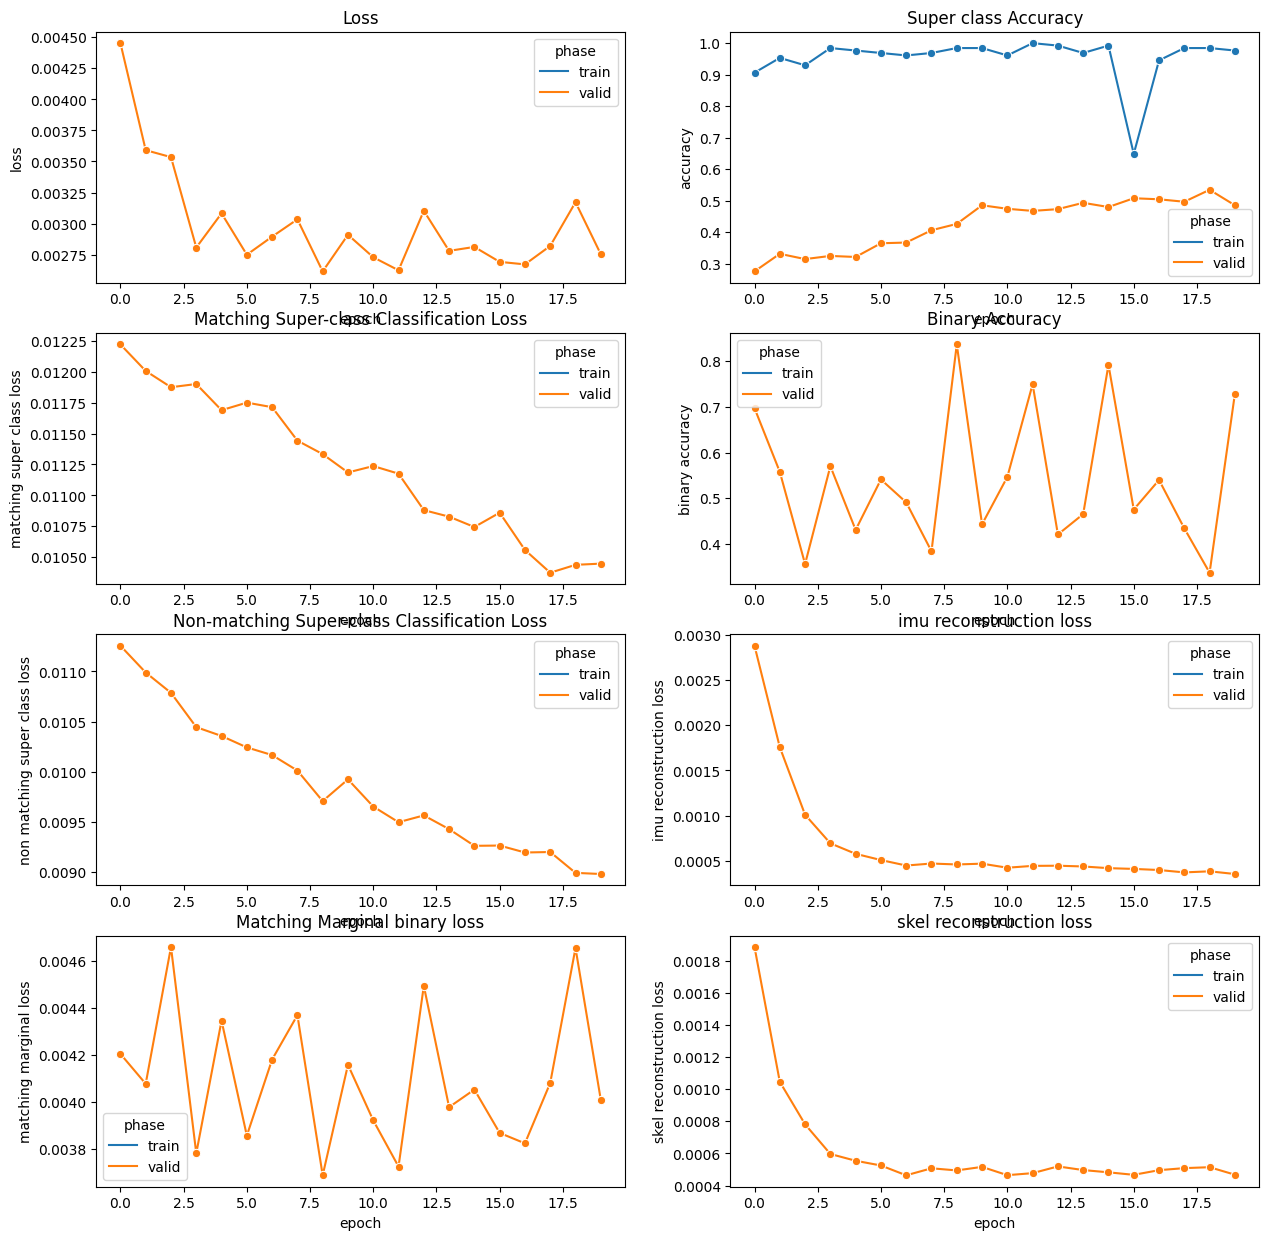

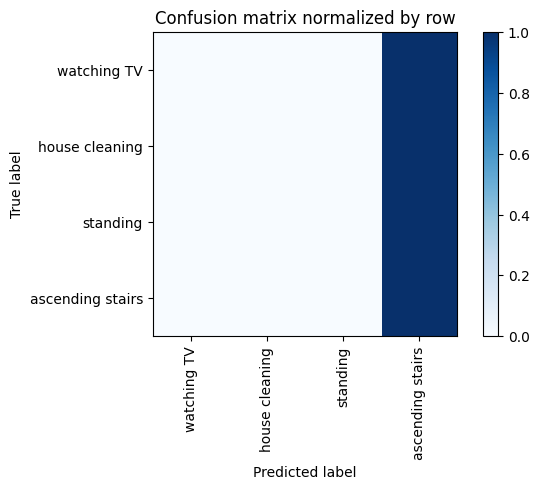

Overall accuracy: 0.203

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        standing       0.000      0.000      0.000      0.344         44|	 ascending stairs: 1.000,	house cleaning: 0.000,	
  house cleaning       0.000      0.000      0.000      0.328         42|	 ascending stairs: 1.000,	standing: 0.000,	
ascending stairs       0.203      1.000      0.338      0.203         26|	 standing: 0.000,	house cleaning: 0.000,	
     watching TV       0.000      0.000      0.000      0.125         16|	 ascending stairs: 1.000,	standing: 0.000,	house cleaning: 0.000,	

----------------------------------------------------------------------------------------------------
     avg / total       0.041      0.203      0.069        1.0        128|	      

{'accuracy': 0.203125, 'precision': 0.05078125, 'recall': 0.25, 'f1': 0.08441558441558442}
================ Fold-1 ================
Unseen Classes : ['walking', 'rope jumping', 'sitting', 'descending 

Training Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/71 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.385



train:   0%|          | 0/71 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.391



train:   0%|          | 0/71 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.401



train:   0%|          | 0/71 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.394



train:   0%|          | 0/71 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.420



train:   0%|          | 0/71 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.404



train:   0%|          | 0/71 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.445



train:   0%|          | 0/71 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.463



train:   0%|          | 0/71 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.500



train:   0%|          | 0/71 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.496



train:   0%|          | 0/71 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.590



train:   0%|          | 0/71 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.600



train:   0%|          | 0/71 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.650



train:   0%|          | 0/71 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.665



train:   0%|          | 0/71 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.642



train:   0%|          | 0/71 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.689



train:   0%|          | 0/71 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.724



train:   0%|          | 0/71 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.758



train:   0%|          | 0/71 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.785



train:   0%|          | 0/71 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.825



  0%|          | 0/20 [00:00<?, ?batch/s]

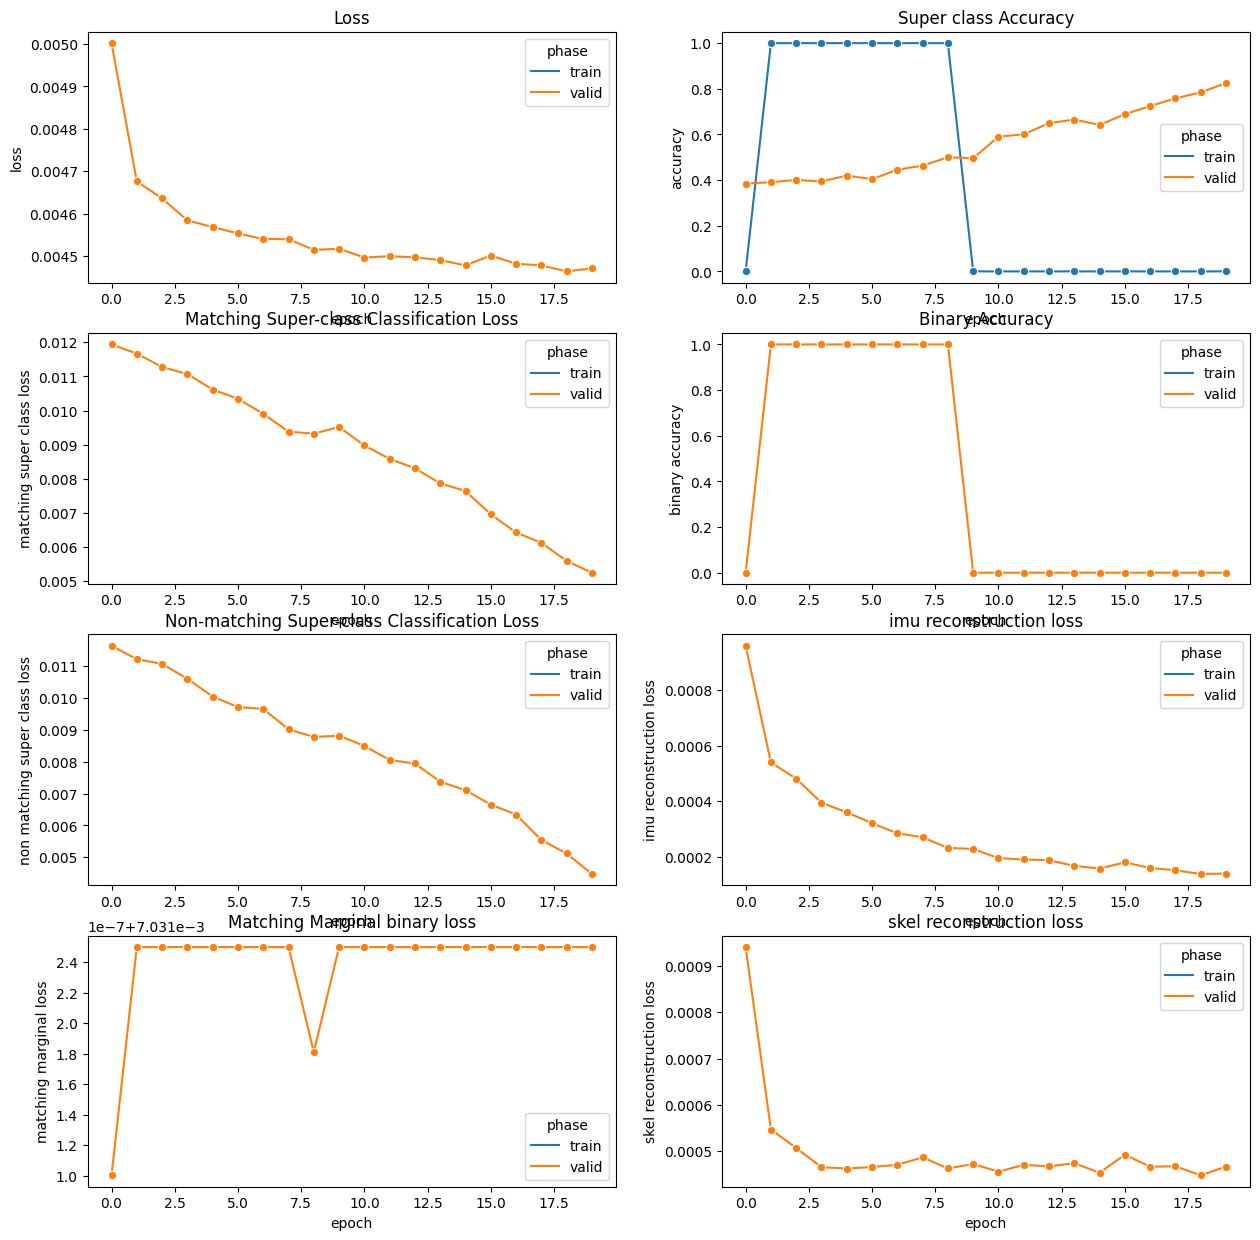

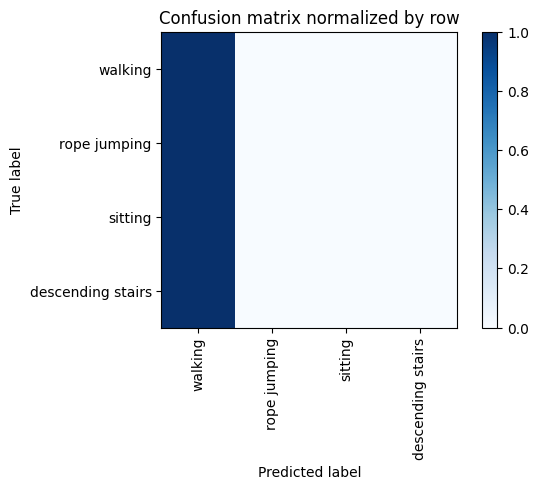

Overall accuracy: 0.445

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walking       0.445      1.000      0.616      0.445         57|	 descending stairs: 0.000,	sitting: 0.000,	
          sitting       0.000      0.000      0.000      0.352         45|	 walking: 1.000,	descending stairs: 0.000,	
descending stairs       0.000      0.000      0.000      0.133         17|	 walking: 1.000,	sitting: 0.000,	
     rope jumping       0.000      0.000      0.000      0.070          9|	 walking: 1.000,	descending stairs: 0.000,	sitting: 0.000,	

----------------------------------------------------------------------------------------------------
      avg / total       0.198      0.445      0.274        1.0        128|	      

{'accuracy': 0.4453125, 'precision': 0.111328125, 'recall': 0.25, 'f1': 0.15405405405405406}
================ Fold-2 ================
Unseen Classes : ['playing soccer', 'lying', 'vacuum cleaning', 'computer work']


Training Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/65 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.397



train:   0%|          | 0/65 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.474



train:   0%|          | 0/65 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.446



train:   0%|          | 0/65 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.474



train:   0%|          | 0/65 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.468



train:   0%|          | 0/65 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.489



train:   0%|          | 0/65 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.490



train:   0%|          | 0/65 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.570



train:   0%|          | 0/65 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.573



train:   0%|          | 0/65 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.579



train:   0%|          | 0/65 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.705



train:   0%|          | 0/65 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.653



train:   0%|          | 0/65 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.696



train:   0%|          | 0/65 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.724



train:   0%|          | 0/65 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.714



train:   0%|          | 0/65 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.790



train:   0%|          | 0/65 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.752



train:   0%|          | 0/65 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.819



train:   0%|          | 0/65 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.836



train:   0%|          | 0/65 [00:00<?, ?batch/s]

train:   0%|          | 0/7 [00:00<?, ?batch/s]

Overall accuracy: 0.806



  0%|          | 0/27 [00:00<?, ?batch/s]

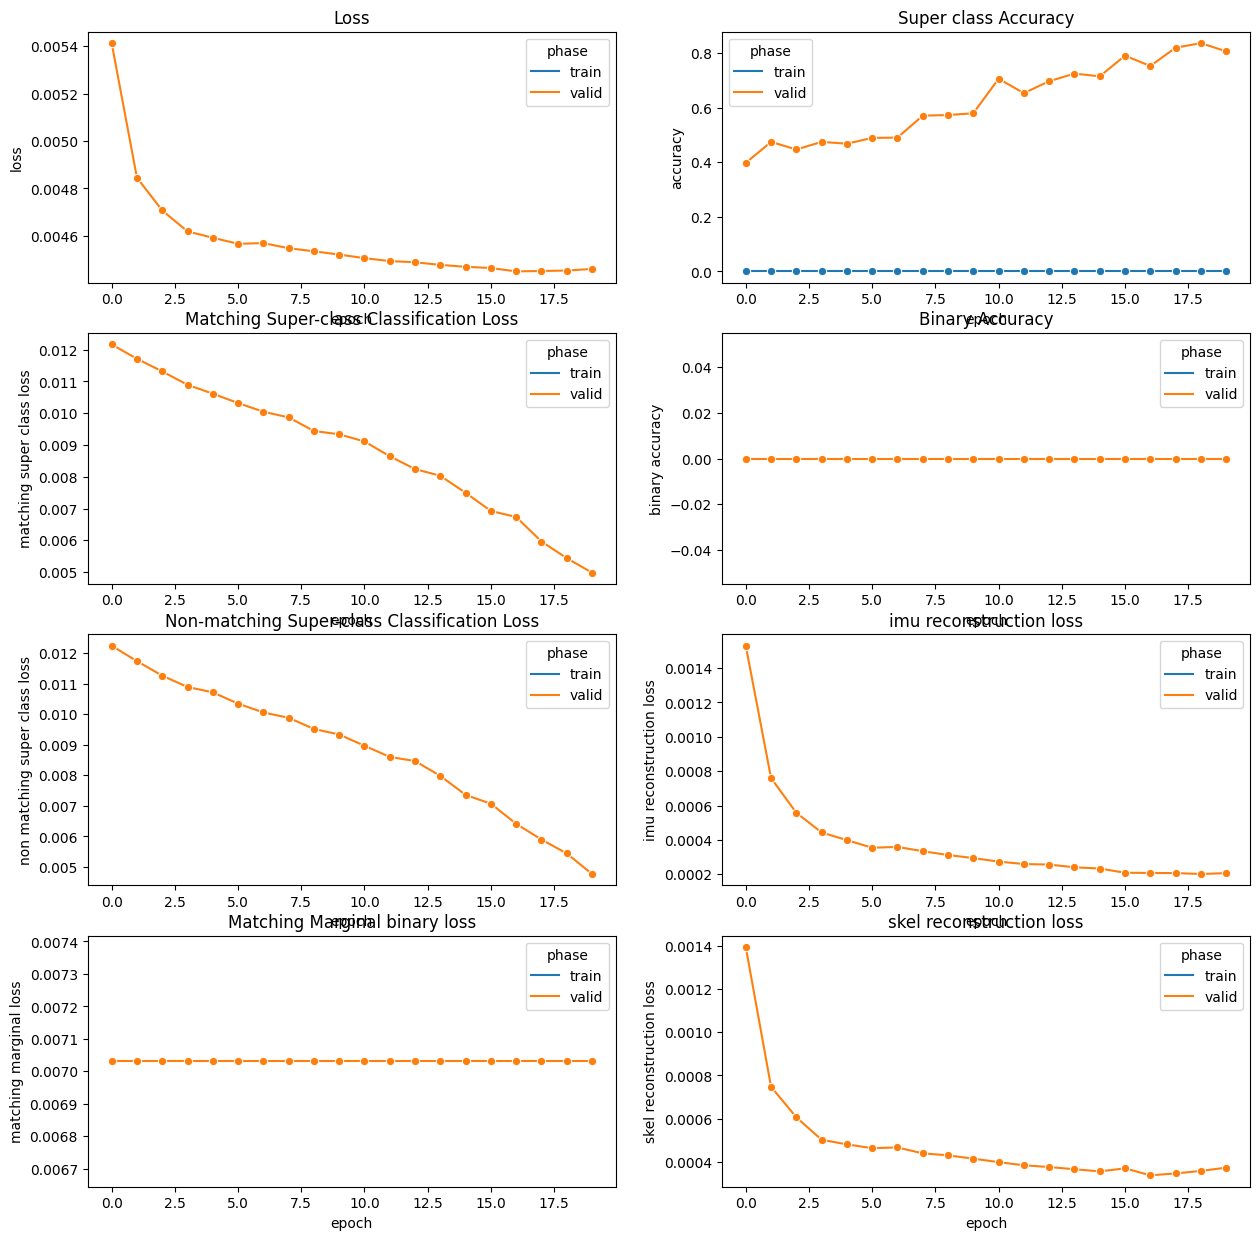

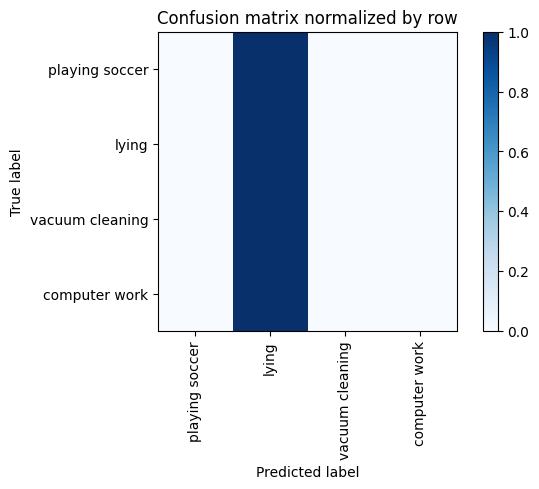

Overall accuracy: 0.320

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  computer work       0.000      0.000      0.000      0.438         56|	 lying: 1.000,	vacuum cleaning: 0.000,	
          lying       0.320      1.000      0.485      0.320         41|	 computer work: 0.000,	vacuum cleaning: 0.000,	
vacuum cleaning       0.000      0.000      0.000      0.156         20|	 lying: 1.000,	computer work: 0.000,	
 playing soccer       0.000      0.000      0.000      0.086         11|	 lying: 1.000,	computer work: 0.000,	vacuum cleaning: 0.000,	

----------------------------------------------------------------------------------------------------
    avg / total       0.103      0.320      0.155        1.0        128|	      

{'accuracy': 0.3203125, 'precision': 0.080078125, 'recall': 0.25, 'f1': 0.12130177514792899}
================ Fold-3 ================
Unseen Classes : ['cycling', 'running', 'Nordic walking']
seen classes >  ['lying', 'si

Training Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/75 [00:00<?, ?batch/s]

train:   0%|          | 0/8 [00:00<?, ?batch/s]

Overall accuracy: 0.266



train:   0%|          | 0/75 [00:00<?, ?batch/s]

train:   0%|          | 0/8 [00:00<?, ?batch/s]

Overall accuracy: 0.346



train:   0%|          | 0/75 [00:00<?, ?batch/s]

train:   0%|          | 0/8 [00:00<?, ?batch/s]

Overall accuracy: 0.350



train:   0%|          | 0/75 [00:00<?, ?batch/s]

train:   0%|          | 0/8 [00:00<?, ?batch/s]

Overall accuracy: 0.378



train:   0%|          | 0/75 [00:00<?, ?batch/s]

train:   0%|          | 0/8 [00:00<?, ?batch/s]

Overall accuracy: 0.354



train:   0%|          | 0/75 [00:00<?, ?batch/s]

train:   0%|          | 0/8 [00:00<?, ?batch/s]

Overall accuracy: 0.399



train:   0%|          | 0/75 [00:00<?, ?batch/s]

train:   0%|          | 0/8 [00:00<?, ?batch/s]

Overall accuracy: 0.389



train:   0%|          | 0/75 [00:00<?, ?batch/s]

train:   0%|          | 0/8 [00:00<?, ?batch/s]

Overall accuracy: 0.400



train:   0%|          | 0/75 [00:00<?, ?batch/s]

train:   0%|          | 0/8 [00:00<?, ?batch/s]

Overall accuracy: 0.486



train:   0%|          | 0/75 [00:00<?, ?batch/s]

train:   0%|          | 0/8 [00:00<?, ?batch/s]

Overall accuracy: 0.487



train:   0%|          | 0/75 [00:00<?, ?batch/s]

train:   0%|          | 0/8 [00:00<?, ?batch/s]

Overall accuracy: 0.511



train:   0%|          | 0/75 [00:00<?, ?batch/s]

train:   0%|          | 0/8 [00:00<?, ?batch/s]

Overall accuracy: 0.536



train:   0%|          | 0/75 [00:00<?, ?batch/s]

train:   0%|          | 0/8 [00:00<?, ?batch/s]

Overall accuracy: 0.635



train:   0%|          | 0/75 [00:00<?, ?batch/s]

train:   0%|          | 0/8 [00:00<?, ?batch/s]

Overall accuracy: 0.639



train:   0%|          | 0/75 [00:00<?, ?batch/s]

train:   0%|          | 0/8 [00:00<?, ?batch/s]

Overall accuracy: 0.677



train:   0%|          | 0/75 [00:00<?, ?batch/s]

train:   0%|          | 0/8 [00:00<?, ?batch/s]

Overall accuracy: 0.706



train:   0%|          | 0/75 [00:00<?, ?batch/s]

train:   0%|          | 0/8 [00:00<?, ?batch/s]

Overall accuracy: 0.760



train:   0%|          | 0/75 [00:00<?, ?batch/s]

train:   0%|          | 0/8 [00:00<?, ?batch/s]

Overall accuracy: 0.807



train:   0%|          | 0/75 [00:00<?, ?batch/s]

train:   0%|          | 0/8 [00:00<?, ?batch/s]

Overall accuracy: 0.868



train:   0%|          | 0/75 [00:00<?, ?batch/s]

train:   0%|          | 0/8 [00:00<?, ?batch/s]

Overall accuracy: 0.896



  0%|          | 0/16 [00:00<?, ?batch/s]

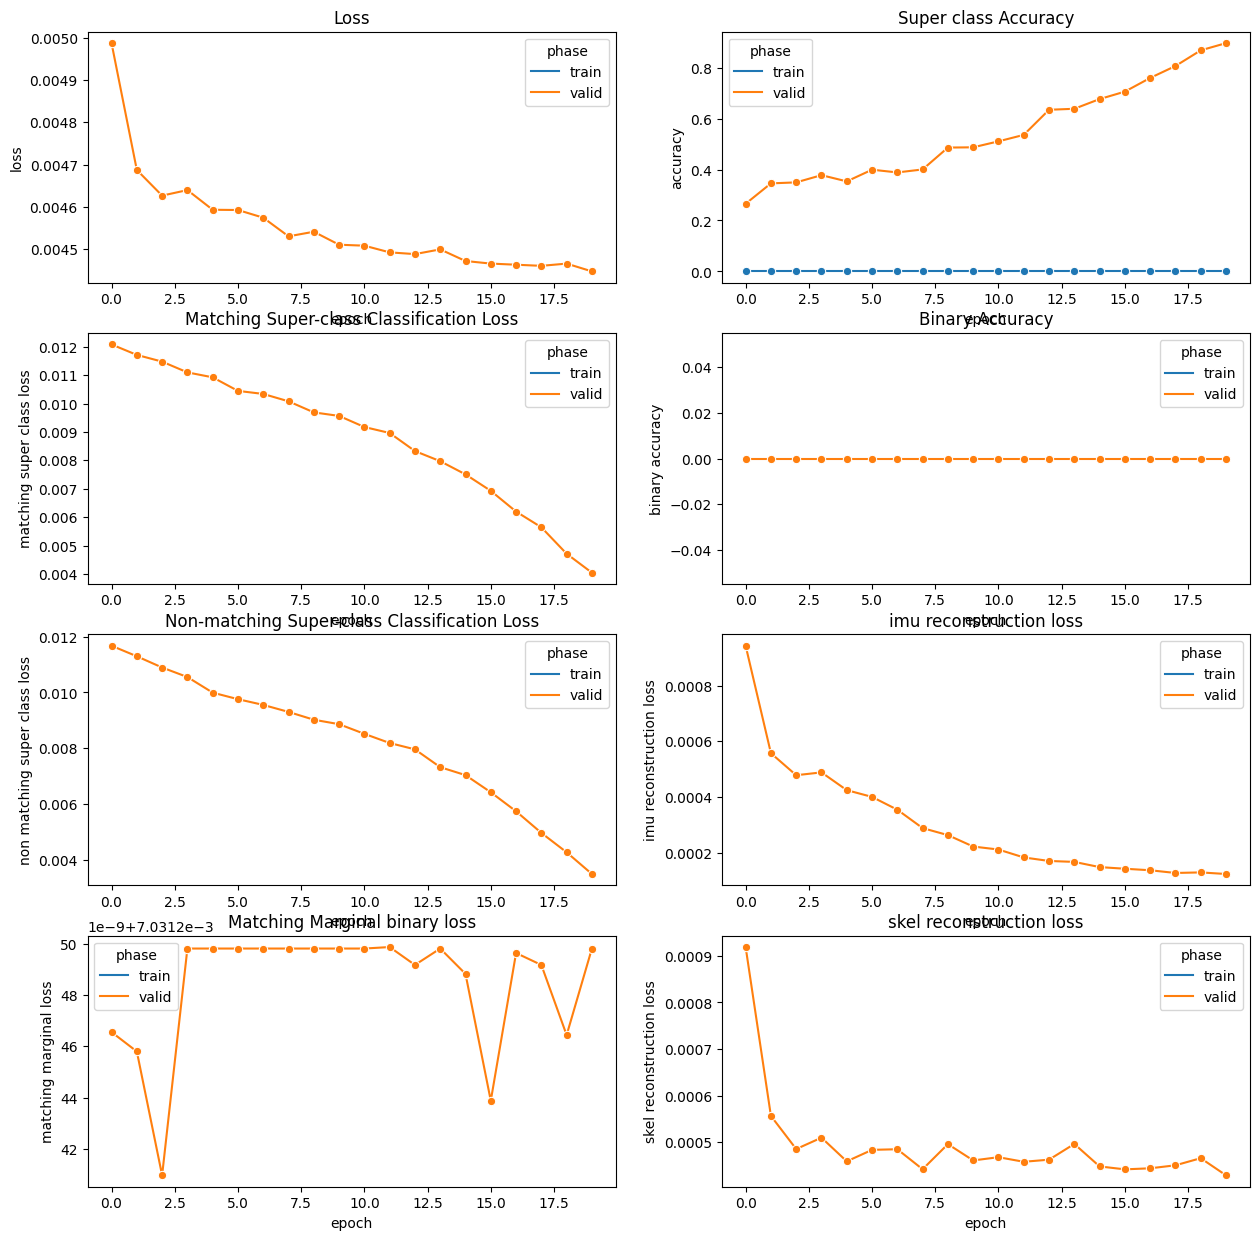

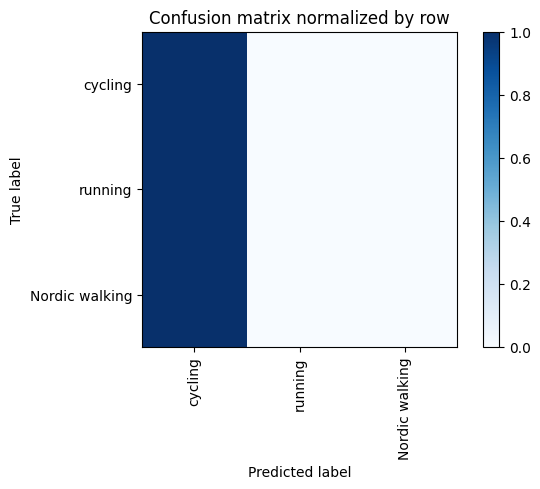

Overall accuracy: 0.281

                 precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Nordic walking       0.000      0.000      0.000      0.492         63|	 cycling: 1.000,	running: 0.000,	
       cycling       0.281      1.000      0.439      0.281         36|	 Nordic walking: 0.000,	running: 0.000,	
       running       0.000      0.000      0.000      0.227         29|	 cycling: 1.000,	Nordic walking: 0.000,	

----------------------------------------------------------------------------------------------------
   avg / total       0.079      0.281      0.123        1.0        128|	      

{'accuracy': 0.28125, 'precision': 0.09375, 'recall': 0.3333333333333333, 'f1': 0.14634146341463414}
================ Fold-4 ================
Unseen Classes : ['ironing', 'car driving', 'folding laundry']
seen classes >  ['lying', 'sitting', 'standing', 'walking', 'running', 'cycling', 'Nordic walking', 'watching TV', 'computer work', 'ascending stairs', 'descending st

Training Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/76 [00:00<?, ?batch/s]

train:   0%|          | 0/8 [00:00<?, ?batch/s]

Overall accuracy: 0.250



train:   0%|          | 0/76 [00:00<?, ?batch/s]

train:   0%|          | 0/8 [00:00<?, ?batch/s]

Overall accuracy: 0.342



train:   0%|          | 0/76 [00:00<?, ?batch/s]

train:   0%|          | 0/8 [00:00<?, ?batch/s]

Overall accuracy: 0.354



train:   0%|          | 0/76 [00:00<?, ?batch/s]

train:   0%|          | 0/8 [00:00<?, ?batch/s]

Overall accuracy: 0.399



train:   0%|          | 0/76 [00:00<?, ?batch/s]

train:   0%|          | 0/8 [00:00<?, ?batch/s]

Overall accuracy: 0.446



train:   0%|          | 0/76 [00:00<?, ?batch/s]

train:   0%|          | 0/8 [00:00<?, ?batch/s]

Overall accuracy: 0.388



train:   0%|          | 0/76 [00:00<?, ?batch/s]

train:   0%|          | 0/8 [00:00<?, ?batch/s]

Overall accuracy: 0.377



train:   0%|          | 0/76 [00:00<?, ?batch/s]

train:   0%|          | 0/8 [00:00<?, ?batch/s]

Overall accuracy: 0.428



train:   0%|          | 0/76 [00:00<?, ?batch/s]

train:   0%|          | 0/8 [00:00<?, ?batch/s]

Overall accuracy: 0.419



train:   0%|          | 0/76 [00:00<?, ?batch/s]

train:   0%|          | 0/8 [00:00<?, ?batch/s]

Overall accuracy: 0.479



train:   0%|          | 0/76 [00:00<?, ?batch/s]

train:   0%|          | 0/8 [00:00<?, ?batch/s]

Overall accuracy: 0.503



train:   0%|          | 0/76 [00:00<?, ?batch/s]

train:   0%|          | 0/8 [00:00<?, ?batch/s]

Overall accuracy: 0.521



train:   0%|          | 0/76 [00:00<?, ?batch/s]

train:   0%|          | 0/8 [00:00<?, ?batch/s]

Overall accuracy: 0.490



train:   0%|          | 0/76 [00:00<?, ?batch/s]

train:   0%|          | 0/8 [00:00<?, ?batch/s]

Overall accuracy: 0.509



train:   0%|          | 0/76 [00:00<?, ?batch/s]

train:   0%|          | 0/8 [00:00<?, ?batch/s]

Overall accuracy: 0.561



train:   0%|          | 0/76 [00:00<?, ?batch/s]

train:   0%|          | 0/8 [00:00<?, ?batch/s]

Overall accuracy: 0.552



train:   0%|          | 0/76 [00:00<?, ?batch/s]

train:   0%|          | 0/8 [00:00<?, ?batch/s]

Overall accuracy: 0.562



train:   0%|          | 0/76 [00:00<?, ?batch/s]

train:   0%|          | 0/8 [00:00<?, ?batch/s]

Overall accuracy: 0.557



train:   0%|          | 0/76 [00:00<?, ?batch/s]

train:   0%|          | 0/8 [00:00<?, ?batch/s]

Overall accuracy: 0.577



train:   0%|          | 0/76 [00:00<?, ?batch/s]

train:   0%|          | 0/8 [00:00<?, ?batch/s]

Overall accuracy: 0.589



  0%|          | 0/14 [00:00<?, ?batch/s]

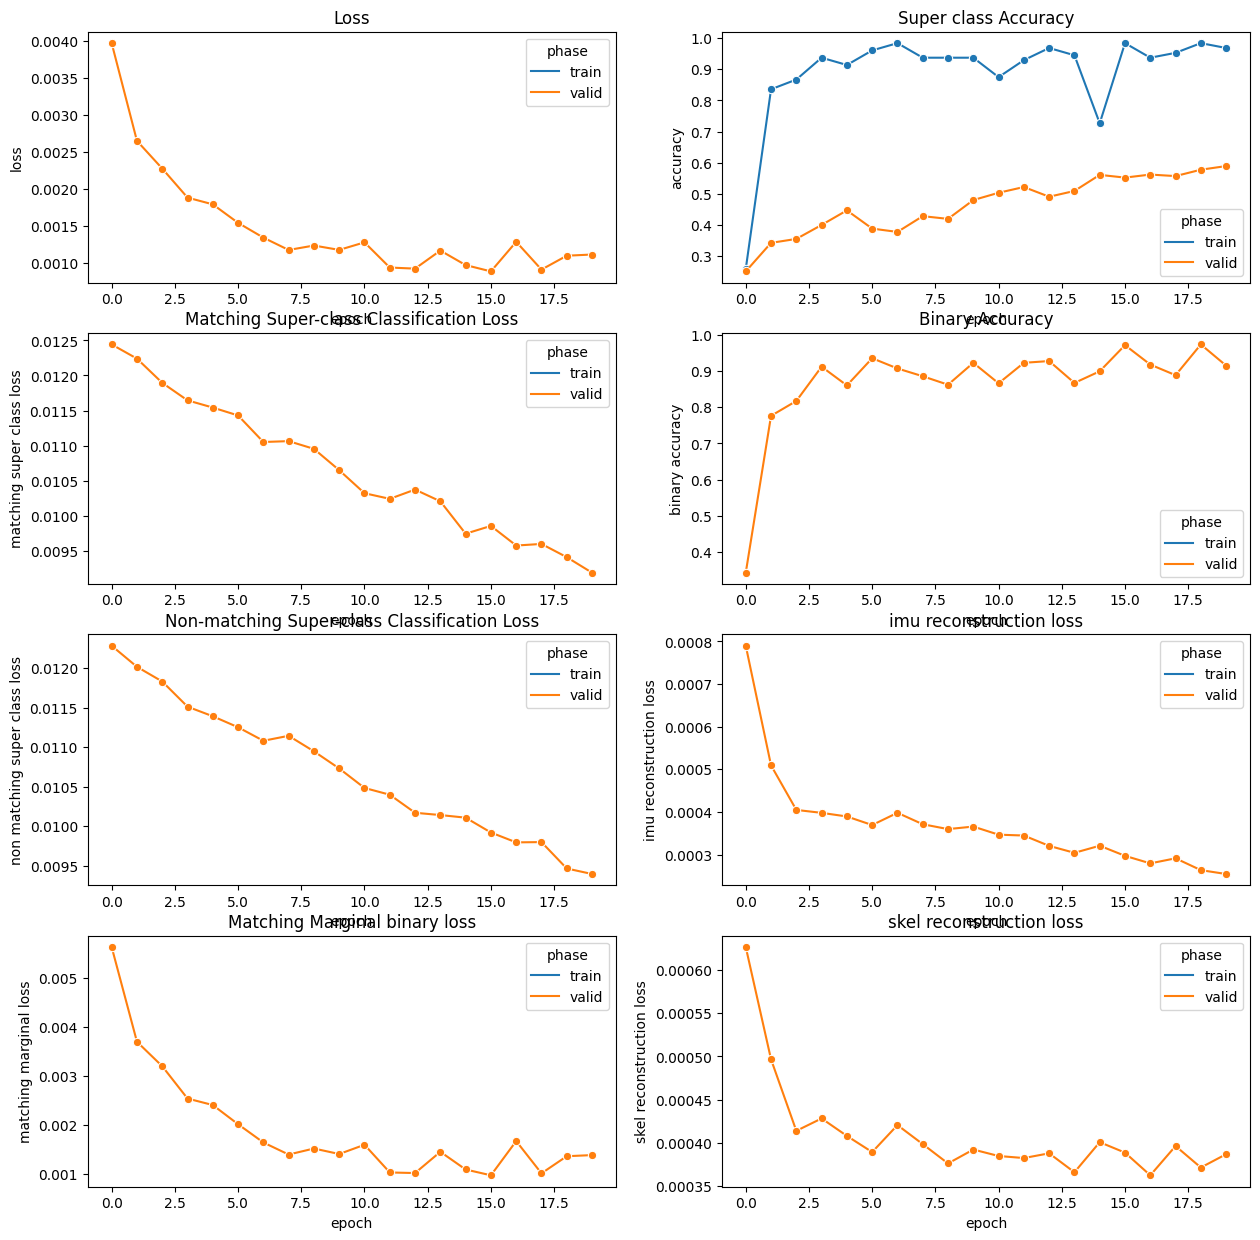

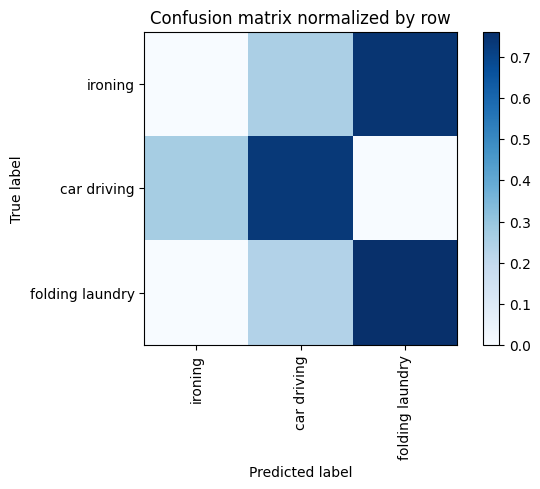

Overall accuracy: 0.336

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        ironing       0.000      0.000      0.000      0.555         71|	 folding laundry: 0.746,	car driving: 0.254,	
folding laundry       0.376      0.762      0.504      0.328         42|	 car driving: 0.238,	ironing: 0.000,	
    car driving       0.282      0.733      0.407      0.117         15|	 ironing: 0.267,	folding laundry: 0.000,	

----------------------------------------------------------------------------------------------------
    avg / total       0.157      0.336      0.213        1.0        128|	      

{'accuracy': 0.3359375, 'precision': 0.2195072900955254, 'recall': 0.4984126984126984, 'f1': 0.3037814717604744}
============== Overall Unseen Classes Performance ==============
accuracy     0.317188
precision    0.111089
recall       0.316349
f1           0.161979
dtype: float64


In [58]:
# run['parameters'] = config
fold_metric_scores = []

for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')

    data_dict = dataReader.generate(unseen_classes=cs, seen_ratio=config['seen_split'], unseen_ratio=0.9, window_size=config['window_size'], window_overlap=config['overlap'], resample_freq=config['freq'])
    all_classes = dataReader.idToLabel
    seen_classes = [all_classes[i] for i in data_dict['seen_classes']]
    unseen_classes = [all_classes[i] for i in data_dict['unseen_classes']]
    print("seen classes > ", seen_classes)
    print("unseen classes > ", unseen_classes)
    # train_n, seq_len, in_ft = data_dict['train']['X'].shape

    print("Initiate IMU datasets ...")
    # build IMU datasets
    train_dt = BaseDataset(imu_data=data_dict['train']['X'], imu_actions=data_dict['train']['y'], skel_data=skeleton_mov, skel_label=skeleton_classes, action2label=action2label, active_cls=seen_classes, class_hierarchy=class_hierarchy, skel_len=timestamps)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build seen eval_dt
    eval_dt = BaseDataset(imu_data=data_dict['eval-seen']['X'], imu_actions=data_dict['eval-seen']['y'], skel_data=skeleton_mov, skel_label=skeleton_classes, action2label=action2label, active_cls=seen_classes, class_hierarchy=class_hierarchy, skel_len=timestamps)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build unseen test_dt
    test_dt = UnseenDataset(imu_data=data_dict['test']['X'], imu_actions=data_dict['test']['y'], skel_data=skeleton_mov, skel_label=skeleton_classes, action2label=action2label, active_cls=unseen_classes, skel_len=timestamps)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    
    # build model
    # model_params, _, _ = get_config("/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Devin/SkeletonAE/model_saves/temp_NTURGB120_skeleton_SGN_DSAG_classifier_1024_emb1d/20__epoch50_emb1024_xy.pt", 'cpu')
    model = BaseModel(base_config)
    # _ = model.load_state_dict(model_params, strict=False)
    model.to(device)

    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'])
    loss_modules = {'mul_class': nn.CrossEntropyLoss(), 'neg_super': nn.CrossEntropyLoss(), 'marginal_loss': nn.MarginRankingLoss(margin=0.9), 'trp_marginal': nn.TripletMarginWithDistanceLoss(distance_function=nn.PairwiseDistance()), 'l2_loss': nn.MSELoss()}
    loss_weights = {'alpha': 0.001, 'beta': 0.4, 'gamma': 0.6}
    best_acc = 0.0

    # train the model 
    train_data = []
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
    
        train_metrics = train_step(model, train_dl, optimizer, loss_modules, loss_weights, device, phase='train', loss_alpha=config['loss_alpha'])
        train_metrics['epoch'] = epoch
        train_metrics['phase'] = 'train'
        train_data.append(train_metrics)
        # log(i, 'train', train_metrics)

        eval_metrics = validate_step(model, eval_dl, optimizer, loss_modules, loss_weights, device, seen_classes, phase='train', loss_alpha=config['loss_alpha'], print_report=False, show_plot=False)
        eval_metrics['epoch'] = epoch 
        eval_metrics['phase'] = 'valid'
        train_data.append(eval_metrics)
        # log(i, 'valid', train_metrics)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    train_df = pd.DataFrame().from_records(train_data)
    plot_curves(train_df)

    # replace by best model 
    model.load_state_dict(best_model)
    # save_model(model,notebook_iden,model_iden,i)

    # run evaluation on unseen classes
    test_metrics = unseen_eval(model, test_dl, device, unseen_classes, print_report=True, show_plot=True)
    fold_metric_scores.append(test_metrics)
    # log('test', i, test_metrics)
    print(test_metrics)
    print("="*40)

print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
print(seen_score_df.mean())
# log('global', '',seen_score_df.mean().to_dict())
# run.stop()

In [49]:
torch.cuda.empty_cache()